In [3]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import glob

# Load all CSV files into a single DataFrame
path_to_csv_files = r"C:\Users\Good_\Desktop\Python\Project NHL\Player Stats"  # Replace with the actual path
all_files = glob.glob(path_to_csv_files + "/*.csv")

df_list = []
for filename in all_files:
    df = pd.read_csv(filename)
    df_list.append(df)

# Combine all DataFrames into one
df = pd.concat(df_list, ignore_index=True)

# Calculate Points per Game and add it as a new column
df['P/G'] = df['I_F_points'] / df['games_played']

# Filter to keep only rows where 'situation' is 'all' or '5on5'
df = df[df['situation'].isin(['all', '5on5'])]

# Ensure 'icetime' is in minutes; if it's in seconds, convert to minutes
if df['icetime'].dtype == 'float':
    df['icetime'] /= 60  # Convert from seconds to minutes if needed

# Calculate per 60-minute metrics directly
df['Takeaways_per_60'] = (df['I_F_takeaways'] / df['icetime']) * 60
df['Giveaways_per_60'] = (df['I_F_giveaways'] / df['icetime']) * 60
df['ShotsOnGoal_per_60'] = (df['I_F_shotsOnGoal'] / df['icetime']) * 60
df['PlayContinuedInZone_per_60'] = (df['I_F_playContinuedInZone'] / df['icetime']) * 60
df['UnblockedShotAttempts_per_60'] = (df['I_F_unblockedShotAttempts'] / df['icetime']) * 60

# Display first few rows to verify adjustments
print("Adjusted metrics (first few rows):")
print(df[['shifts', 'icetime', 'I_F_takeaways', 'Takeaways_per_60', 
          'I_F_giveaways', 'Giveaways_per_60', 'I_F_shotsOnGoal', 'ShotsOnGoal_per_60',
          'I_F_playContinuedInZone', 'PlayContinuedInZone_per_60', 'onIce_corsiPercentage', 
           'I_F_unblockedShotAttempts', 'UnblockedShotAttempts_per_60']].head())

def filter_elite_players(df):
    # Ensure 'season' column is present
    if 'season' not in df.columns:
        raise KeyError("'season' column not found in DataFrame")
    
    # Ensure 'playerId' column is present
    if 'playerId' not in df.columns:
        raise KeyError("'playerId' column not found in DataFrame")
    
    elite_players_per_season = pd.DataFrame()

    # Group by season
    for season, group in df.groupby('season'):
        # Filter players with position C, L, or R
        df_forwards = group[group['position'].isin(['C', 'L', 'R'])]
        
        # Filter to keep only rows where 'situation' is 'all'
        df_forwards = df_forwards[df_forwards['situation'] == 'all']
        
        # Calculate Points per Game (P/G)
        df_forwards['P/G'] = df_forwards['I_F_points'] / df_forwards['games_played']
        
        # Filter players who have played at least 40 games
        df_forwards = df_forwards[df_forwards['games_played'] >= 40]
        
        # Determine the threshold for the top 10% based on P/G
        threshold = df_forwards['P/G'].quantile(0.9)
        
        # Select players with P/G above the threshold
        elite_players = df_forwards[df_forwards['P/G'] >= threshold]
        
             # Add season information to the elite players
        elite_players.loc[:, 'season'] = season
        
        # Append to the main DataFrame
        elite_players_per_season = pd.concat([elite_players_per_season, elite_players[['playerId', 'season']]])
    
    return elite_players_per_season

def compare_distributions(df, elite_players, metrics):
    results = {}

    # Ensure the 'season' column is present
    if 'season' not in elite_players.columns:
        raise KeyError("'season' column not found in elite_players DataFrame")

    # Group the elite players by season
    elite_players_grouped = elite_players.groupby('season')['playerId'].unique()

    # Iterate over each season
    for season, elite_ids in elite_players_grouped.items():
        print(f"Processing season: {season}")
        
        # Filter the DataFrame for the current season
        df_season = df[df['season'] == season]
        
        # Split the data into elite and non-elite players for the current season
        for metric in metrics:
            # Ensure the metric column exists in the DataFrame
            if metric not in df_season.columns:
                print(f"Metric '{metric}' not found in DataFrame columns.")
                continue

            # Filter the metrics for elite and non-elite players
            elite = df_season[df_season['playerId'].isin(elite_ids)][metric]
            non_elite = df_season[~df_season['playerId'].isin(elite_ids)][metric]

            # Check if both datasets are non-empty
            if len(elite) == 0 or len(non_elite) == 0:
                print(f"No data available for metric '{metric}' in season {season}. Skipping.")
                continue
            
            # Perform the Mann-Whitney U test to compare the two distributions
            stat, p_value = stats.mannwhitneyu(elite, non_elite, alternative='greater')
            
            # Calculate Cohen's d
            mean_elite, mean_non_elite = elite.mean(), non_elite.mean()
            std_elite, std_non_elite = elite.std(), non_elite.std()
            cohen_d = (mean_elite - mean_non_elite) / np.sqrt((std_elite ** 2 + std_non_elite ** 2) / 2)

            # Store results
            results[(season, metric)] = {'p_value': p_value, 'cohen_d': cohen_d}
    
    return results

# Main analysis loop for your data
metrics_of_interest = ['shifts', 'Takeaways_per_60', 'Giveaways_per_60',
                       'ShotsOnGoal_per_60', 'PlayContinuedInZone_per_60',
                       'onIce_corsiPercentage', 'UnblockedShotAttempts_per_60', 'icetime']

# Perform the analysis
elite_players = filter_elite_players(df)
results = compare_distributions(df, elite_players, metrics_of_interest)

# Convert the results dictionary to a DataFrame
results_df = pd.DataFrame({
    (season, metric): {
        'p_value': result['p_value'],
        'cohen_d': result['cohen_d']
    } 
    for (season, metric), result in results.items()
}).T.reset_index()

results_df.columns = ['season', 'metric', 'p_value', 'cohen_d']



Adjusted metrics (first few rows):
    shifts      icetime  I_F_takeaways  Takeaways_per_60  I_F_giveaways  \
1   2026.0  1765.966667           28.0          0.951320           44.0   
2   1480.0  1234.216667           17.0          0.826435           33.0   
6   1305.0   975.883333           44.0          2.705241           34.0   
7    896.0   645.100000           29.0          2.697256           16.0   
11   482.0   356.133333            1.0          0.168476            7.0   

    Giveaways_per_60  I_F_shotsOnGoal  ShotsOnGoal_per_60  \
1           1.494932            158.0            5.368165   
2           1.604256             65.0            3.159899   
6           2.090414            101.0            6.209759   
7           1.488141             66.0            6.138583   
11          1.179334              5.0            0.842381   

    I_F_playContinuedInZone  PlayContinuedInZone_per_60  \
1                     112.0                    3.805281   
2                      38.0  

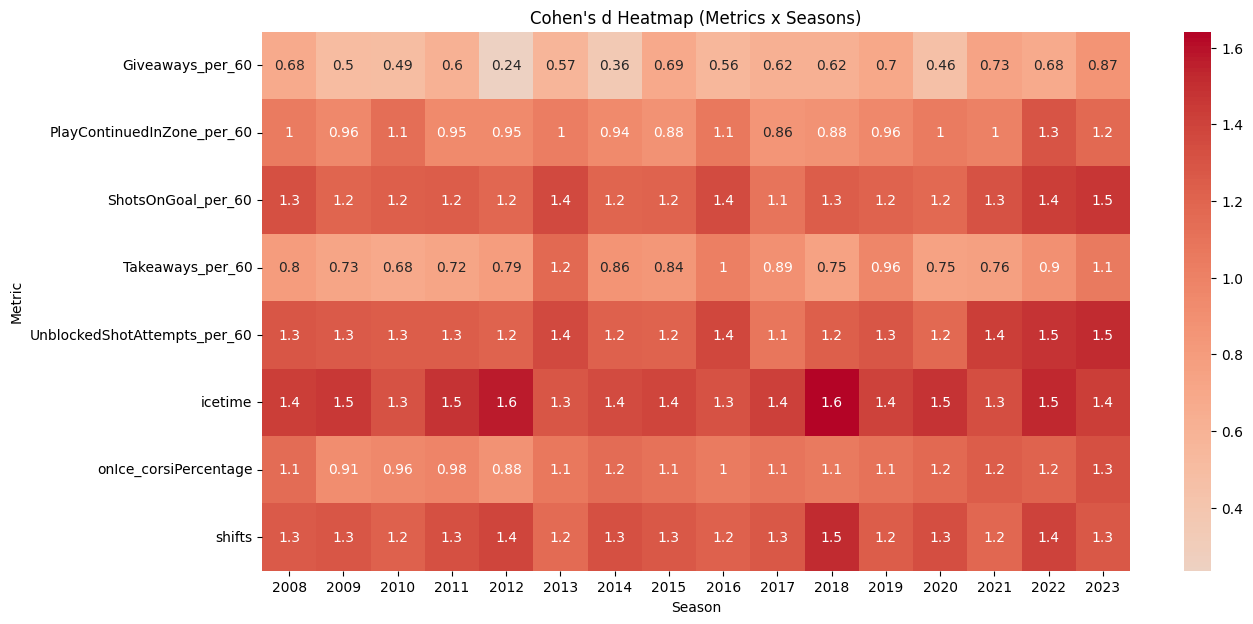

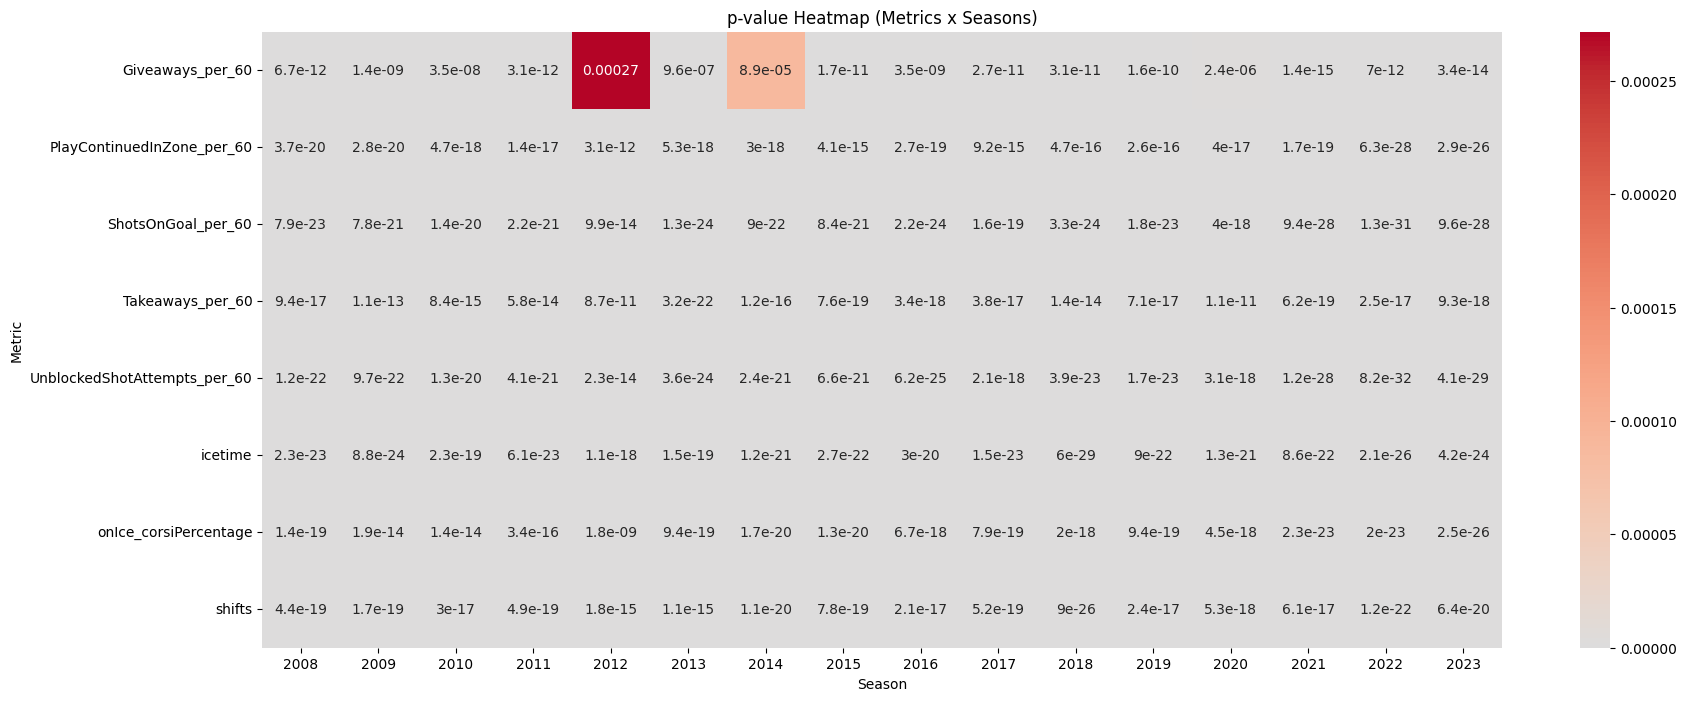

In [2]:
# Pivot the DataFrame for heatmap plotting
heatmap_df_cohen_d = results_df.pivot(index="metric", columns="season", values="cohen_d")
heatmap_df_p_value = results_df.pivot(index="metric", columns="season", values="p_value")

# Create the heatmaps
plt.figure(figsize=(14, 7))
sns.heatmap(heatmap_df_cohen_d, annot=True, cmap="coolwarm", center=0)
plt.title('Cohen\'s d Heatmap (Metrics x Seasons)')
plt.xlabel('Season')
plt.ylabel('Metric')
plt.show()

plt.figure(figsize=(20, 8))
sns.heatmap(heatmap_df_p_value, annot=True, cmap="coolwarm", center=0)
plt.title('p-value Heatmap (Metrics x Seasons)')
plt.xlabel('Season')
plt.ylabel('Metric')
plt.show()
